In [ ]:
# connect to google colab
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install -U torchtext==0.6.0

     |████████████████████████████████| 64 kB 2.6 MB/s 
     |████████████████████████████████| 1.2 MB 26.1 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.10.0
    Uninstalling torchtext-0.10.0:
      Successfully uninstalled torchtext-0.10.0


In [ ]:
# base path
DATA_PATH = './drive/MyDrive/fyp-code/codes/data/emotion_classification/'
SAVED_MODEL_PATH = './drive/MyDrive/fyp-code/codes/model/emotion_classification/'

## Libraries

In [ ]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys
import torch
from time import time

# Preliminaries
from torch import Tensor
import torch.nn as nn
#from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchtext import data, datasets
#from torchtext.data import Field, TabularDataset, BucketIterator
#from torchtext.vocab import Vectors, GloVe
import torch.optim as optim

# Evaluation
from sklearn.metrics import auc, roc_curve, accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# For inference
import spacy
nlp = spacy.load('en')

# check if it is running with GPU or not
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Load the data using custom dataset

In [ ]:
class CustomDataset(data.Dataset):
    def __init__(self, df, fields, is_test=False, **kwargs):
        examples = []
        for i, row in df.iterrows():
            label = row.Label #if not is_test else None
            text = row.text_cleaned
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    @classmethod
    def splits(cls, fields, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)
        data_field = fields

        if train_df is not None:
            train_data = cls(train_df.copy(), data_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), data_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), data_field, False, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)

## Data Handler for RNN models

In [ ]:
# helper function to handle the train and validation data to train the model
def data_handler(root_data_path, train_data_filename, val_data_filename, batch_size=32):
    # defining the fields needed
    TEXT = data.Field(tokenize = 'spacy', batch_first=True, include_lengths = True)
    LABEL = data.LabelField(dtype = torch.float, batch_first=True)
    fields = [('text',TEXT), ('label',LABEL)]

    # load data in pandas dataframe format
    train_data_raw = pd.read_csv(root_data_path + train_data_filename)
    val_data_raw = pd.read_csv(root_data_path + val_data_filename)

    # load the data from pytorch custom dataset class as defined
    train_ds, val_ds = CustomDataset.splits(fields, 
                                            train_df=train_data_raw, 
                                            val_df=val_data_raw)
    
    # defining the vocabulary
    MAX_VOCAB_SIZE = 100000

    TEXT.build_vocab(train_ds, 
                    max_size = MAX_VOCAB_SIZE, 
                    vectors='fasttext.simple.300d',
                    #vectors='fasttext.en.300d',
                    #vectors='glove.6B.300d',
                    unk_init = torch.Tensor.zero_)
    LABEL.build_vocab(train_ds)

    # No. of unique tokens in text
    print("Size of TEXT vocabulary:",len(TEXT.vocab))

    # No. of unique tokens in label
    print("Size of LABEL vocabulary:",len(LABEL.vocab))

    # Commonly used words
    print(f'Top 10 most frequent word in the vocabulary: {TEXT.vocab.freqs.most_common(10)}')  

    # The whole word dictionary
    #print(TEXT.vocab.stoi) 

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)

    train_iterator, valid_iterator = data.BucketIterator.splits((train_ds, val_ds), 
                                                                batch_size = batch_size, 
                                                                sort_within_batch = True, 
                                                                device = device)
    
    return TEXT, LABEL, device, train_iterator, valid_iterator

In [ ]:
# load data in pandas dataframe format
#train_data_raw = pd.read_csv(DATA_PATH+'emotion_classification_cleaned_toy_data_train.csv')
#val_data_raw = pd.read_csv(DATA_PATH+'emotion_classification_cleaned_toy_data_dev.csv')
# train_data_raw = pd.read_csv(DATA_PATH+'emotion_classification_cleaned_short_text_train.csv')
# val_data_raw = pd.read_csv(DATA_PATH+'emotion_classification_cleaned_short_text_dev.csv')
# train_data_raw = pd.read_csv(DATA_PATH+'emotion_classification_cleaned_long_text_train.csv')
# val_data_raw = pd.read_csv(DATA_PATH+'emotion_classification_cleaned_long_text_dev.csv')
#train_data_raw = pd.read_csv(DATA_PATH+'emotion_classification_cleaned_combined_text_train.csv')
#val_data_raw = pd.read_csv(DATA_PATH+'emotion_classification_cleaned_combined_text_dev.csv')

## Build Model

In [ ]:
# RNN Models
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, rnn_type, dropout, pad_idx):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.rnn_type = rnn_type

        # LSTM
        if self.rnn_type == 'lstm':
            self.rnn = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers=n_layers, 
                            bidirectional=bidirectional, 
                            dropout=dropout,
                            batch_first=True)
        # GRU
        else:
            self.rnn = nn.GRU(embedding_dim, 
                            hidden_dim, 
                            num_layers=n_layers, 
                            bidirectional=bidirectional, 
                            dropout=dropout,
                            batch_first=True)

        # bilstm or bigru
        # if bidirectional:
        #     self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        #     self.fc2 = nn.Linear(hidden_dim, 1)
        # else:
        # # single direction lstm or gru
        #     self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        #     self.fc2 = nn.Linear(hidden_dim, 1)
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        # text = [batch size, sent len]
        # embedded = [batch size, sent len, emb dim]
        embedded = self.embedding(text)
        
        # pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, 
                                                            text_lengths.to('cpu'), 
                                                            batch_first=True)
        
        # hidden = [num layers * num directions, batch size, hid dim]
        # cell = [num layers * num directions, batch size, hid dim]

        # lstm
        if self.rnn_type == 'lstm':
            packed_output, (hidden, cell) = self.rnn(packed_embedded)
        # gru
        else:
            packed_output, hidden = self.rnn(packed_embedded)
        
        #unpack sequence
        # output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        # output = [sent len, batch size, hid dim * num directions]
        # output over padding tokens are zero tensors
        
        # concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        # and apply dropout
        #hidden = [batch size, hid dim * num directions]
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        
        output = self.fc1(hidden)
        output = self.dropout(self.fc2(output))
                    
        return output

## Training the model

In [ ]:
# helper functions

#No. of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

# training function 
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    steps = 0
    model.train()
    
    for idx, batch in enumerate(iterator):
        text, text_lengths = batch.text
        
        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)

        loss.backward()
        optimizer.step()
        steps += 1
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        if steps % 50 == 0:
            #print (f'Idx: {idx+1}, Training Loss: {loss.item():.4f}, Training Acc: {acc.item(): .4f}')
            print (f'Idx: {idx+1}, Train Loss: {loss.item():.4f}')

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0
    true_list = []
    pred_list = []
    pred_prob_list = []
    
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            #print(predictions)
            #print(torch.round(torch.sigmoid(predictions)))
            #print(batch.label)
            # keep a record of the prediction and the ground truth value for computation of F1 score
            pred_list.extend(torch.round(torch.sigmoid(predictions)).tolist())
            # get the probability for the ROC Curve instead of the argmax
            pred_prob_list.extend(torch.sigmoid(predictions).tolist())
            true_list.extend(batch.label.tolist())
            #print(pred_list)
            #print(true_list)
            #compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            #keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), [int(x) for x in true_list], [int(x) for x in pred_list], pred_prob_list

# A function to show f1-score and confusion matrix
def f1_confusion_matrix(true_list, pred_list):
    labels = ['0','1']
    val_tuple = list(zip(true_list, pred_list))
    val_df = pd.DataFrame(val_tuple, columns=['true_list', 'pred_list'])
    #print(val_df.head(3))
    # get the multi-class F1-score to see the distribution of the predictions
    print('F1-Score and Confusion Matrix of the Validation Set')
    print()
    #print(classification_report(true_list, pred_list, target_names=labels, digits=4))
    print(classification_report(list(val_df['true_list']), list(val_df['pred_list']), target_names=labels, digits=4))
    print('\n')

    # confusion matrix
    #cm_sns = pd.crosstab(true_list, pred_list, rownames=['Actual'], colnames=['Predicted'])
    cm_sns = pd.crosstab(val_df['true_list'], val_df['pred_list'], rownames=['Actual'], colnames=['Predicted'])
    plt.subplots(figsize=(8,6))
    sns.heatmap(cm_sns, annot=True, fmt="d", cmap='BuGn')
    plt.show()

# get the ROC-AUC values and parameters for the graph
def get_roc_auc(true_list, pred_list):
    fpr, tpr, thresholds = roc_curve(true_list, pred_list)
    get_auc_value = auc(fpr, tpr)
    return fpr, tpr, get_auc_value, thresholds

# train model wrapper
def fit_model(model, device, learning_rate, num_epochs, root_path, filepath):
    
    best_valid_loss = float('inf')
    model.to(device)

    # Loss and optimizer
    criterion = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.Adam(model.parameters(), 
                                 lr=learning_rate,
                                 weight_decay =1e-4,
                                 eps=1e-7)
    
    # set the LR scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                           mode='min', 
                                                           factor=0.1, 
                                                           patience=3, 
                                                           min_lr=1e-5,
                                                           verbose=True)
    
    # fixed parameters to perform early stopping
    n_epochs_stop = 3
    epochs_no_improve = 0
    early_stop = False
    min_val_loss = np.inf
    threshold = 0
    epoch_list = []
    train_loss_list = []
    val_loss_list = []

    for epoch in range(num_epochs):
        # time for every epoch
        t = time()
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
        valid_loss, valid_acc, true_list, pred_list, pred_prob_list = evaluate(model, valid_iterator, criterion)

        #print(f'Epoch {epoch+1}: Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.5f} | Val. Loss: {valid_loss:.5f} | Val. Acc: {valid_acc:.5f} | Time Taken: {time()-t: .3f}s')
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.5f} | Val. Loss: {valid_loss:.5f} | Val. Acc: {valid_acc:.5f} | Time Taken: {time()-t: .3f}s')
        # append the values to plot the graphs
        epoch_list.append(epoch+1)
        train_loss_list.append(train_loss)
        val_loss_list.append(valid_loss)

        # add the scheduler code
        scheduler.step(valid_loss)

        #save the best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            #torch.save(model.state_dict(), SAVED_MODEL_PATH+'toy_dataset_model.pt')
            torch.save(model.state_dict(), root_path+filepath)
        
         # --- EARLY STOPPING CONDITION ---
        if valid_loss < min_val_loss+threshold: # give some threshold to make the learning less strict
            # resets the no improve counter
            epochs_no_improve = 0
            min_val_loss = valid_loss
        else: # val_loss no improvement
            epochs_no_improve +=1
            print(f"Validation Loss did not improve count: {epochs_no_improve}")
            # set this line as min now
            min_val_loss = valid_loss
        if epoch > 5 and epochs_no_improve == n_epochs_stop:
            print("Training stopped due to early stopping!")
            break
        else: 
            continue
    
    print()
    # plot the loss curve for both the train and the validation set
    plt.plot(epoch_list, train_loss_list, label='Train')
    plt.plot(epoch_list, val_loss_list, label='Valid')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show() 

    # get the f1-score and confusion matrix
    f1_confusion_matrix(true_list, pred_list)

    fpr, tpr, get_auc_value, thresholds = get_roc_auc(true_list, pred_prob_list)
    print(f'\nAUC Score: {get_auc_value}')
    
    return fpr, tpr, get_auc_value, thresholds

## Inserting the model configurations to train the model

**Datasets considered**  
- Toy Dataset  
- Short text Twitter Dataset   
- Long text Reddit Dataset   
- Mixed of Short + Long Text Dataset  

**Tuned Hyperparameters**   
- Unidirectional vs Bidirectional   
- GRU vs LSTM  

**Total Number of models**   
4 x 2 x 2 = 16 models


### CONFIGURATION 1a
**Baseline**  
- Toy Dataset
- Uni-LSTM

Size of TEXT vocabulary: 8448
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('depression', 1803), ('not', 693), ('just', 308), ('anxiety', 279), ('like', 239), ('good', 197), ('day', 195), ('love', 193), ('time', 177), ('know', 161)]
cuda
RNN(
  (embedding): Embedding(8448, 300, padding_idx=1)
  (rnn): LSTM(300, 512, num_layers=4, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 11,030,529 trainable parameters

Idx: 50, Train Loss: 0.4892
Idx: 100, Train Loss: 0.3827
Epoch 1: Train Loss: 0.48721 | Val. Loss: 0.14291 | Val. Acc: 0.98060 | Time Taken:  1.700s
Idx: 50, Train Loss: 0.4252
Idx: 100, Train Loss: 0.3936
Epoch 2: Train Loss: 0.38126 | Val. Loss: 0.08233 | Val. Acc: 0.98384 | Time Taken:  1.623s
Idx: 50, Train Loss: 0.3764
Idx: 100, Train Loss: 0.3257
Epoch 3: Train Loss: 0.35953 | Val. Lo

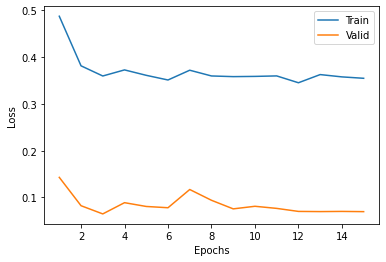

F1-Score and Confusion Matrix of the Validation Set

              precision    recall  f1-score   support

           0     0.9955    0.9712    0.9832       452
           1     0.9720    0.9956    0.9836       453

    accuracy                         0.9834       905
   macro avg     0.9837    0.9834    0.9834       905
weighted avg     0.9837    0.9834    0.9834       905





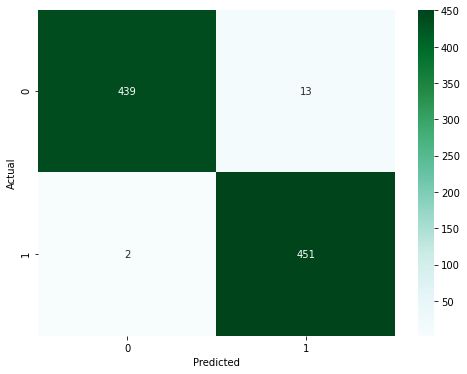


AUC Score: 0.9923469886108344


In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_classification_cleaned_toy_data_train.csv', 
                                                                   val_data_filename='emotion_classification_cleaned_toy_data_dev.csv', 
                                                                   batch_size=32)

MODEL_NAME = 'toy_dataset_uni_lstm_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = False # changeable
RNN_TYPE = 'lstm' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fpr1a, tpr1a, get_auc_value1a, thresholds1a = fit_model(model=model, 
                                                device=device,
                                                learning_rate=LEARNING_RATE,
                                                num_epochs=NUM_EPOCHS,
                                                root_path=SAVED_MODEL_PATH, 
                                                filepath=MODEL_NAME)

ROC Curve


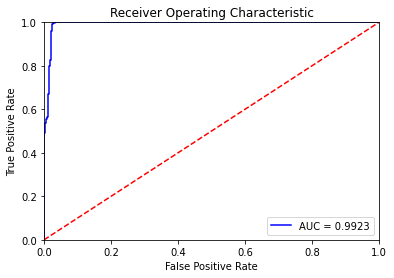

In [ ]:
# try out on displaying the ROC Curve
print('ROC Curve')
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1a, tpr1a, 'b', label = f'AUC = {get_auc_value1a:.4f}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### CONFIGURATION 1b
- Toy Dataset
- BiLSTM

Size of TEXT vocabulary: 8448
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('depression', 1803), ('not', 693), ('just', 308), ('anxiety', 279), ('like', 239), ('good', 197), ('day', 195), ('love', 193), ('time', 177), ('know', 161)]
cuda
RNN(
  (embedding): Embedding(8448, 300, padding_idx=1)
  (rnn): LSTM(300, 512, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 25,292,801 trainable parameters

Idx: 50, Train Loss: 0.3262
Idx: 100, Train Loss: 0.3626
Epoch 1: Train Loss: 0.46427 | Val. Loss: 0.17073 | Val. Acc: 0.93020 | Time Taken:  3.610s
Idx: 50, Train Loss: 0.4545
Idx: 100, Train Loss: 0.4553
Epoch 2: Train Loss: 0.38256 | Val. Loss: 0.06347 | Val. Acc: 0.98491 | Time Taken:  3.539s
Idx: 50, Train Loss: 0.3920
Idx: 100, Train Loss: 0.2856
Epoch 3: Train Los

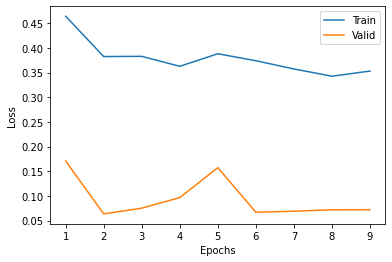

F1-Score and Confusion Matrix of the Validation Set

              precision    recall  f1-score   support

           0     0.9865    0.9735    0.9800       452
           1     0.9739    0.9868    0.9803       453

    accuracy                         0.9801       905
   macro avg     0.9802    0.9801    0.9801       905
weighted avg     0.9802    0.9801    0.9801       905





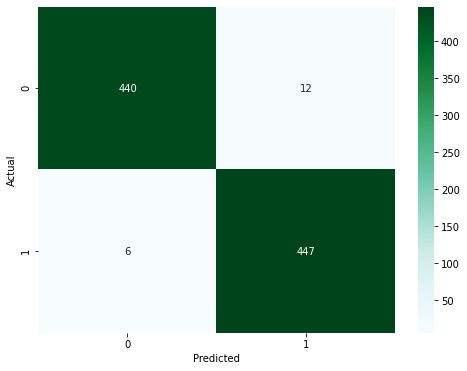


AUC Score: 0.9943640235206783


In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_classification_cleaned_toy_data_train.csv', 
                                                                   val_data_filename='emotion_classification_cleaned_toy_data_dev.csv', 
                                                                   batch_size=32)

MODEL_NAME = 'toy_dataset_bilstm_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = True # changeable
RNN_TYPE = 'lstm' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fpr1b, tpr1b, get_auc_value1b, thresholds1b = fit_model(model=model, 
                                                device=device,
                                                learning_rate=LEARNING_RATE,
                                                num_epochs=NUM_EPOCHS,
                                                root_path=SAVED_MODEL_PATH, 
                                                filepath=MODEL_NAME)

### CONFIGURATION 1c
- Toy Dataset
- Uni-GRU

Size of TEXT vocabulary: 8448
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('depression', 1803), ('not', 693), ('just', 308), ('anxiety', 279), ('like', 239), ('good', 197), ('day', 195), ('love', 193), ('time', 177), ('know', 161)]
cuda
RNN(
  (embedding): Embedding(8448, 300, padding_idx=1)
  (rnn): GRU(300, 512, num_layers=4, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 9,037,825 trainable parameters

Idx: 50, Train Loss: 0.4174
Idx: 100, Train Loss: 0.3341
Epoch 1: Train Loss: 0.48166 | Val. Loss: 0.09558 | Val. Acc: 0.98599 | Time Taken:  1.427s
Idx: 50, Train Loss: 0.3763
Idx: 100, Train Loss: 0.3392
Epoch 2: Train Loss: 0.38258 | Val. Loss: 0.06851 | Val. Acc: 0.98384 | Time Taken:  1.346s
Idx: 50, Train Loss: 0.3357
Idx: 100, Train Loss: 0.3907
Epoch 3: Train Loss: 0.36021 | Val. Loss

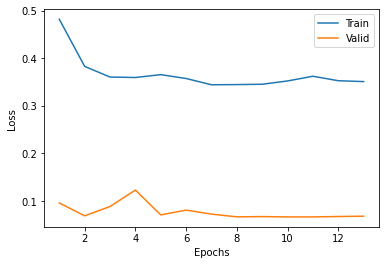

F1-Score and Confusion Matrix of the Validation Set

              precision    recall  f1-score   support

           0     0.9910    0.9712    0.9810       452
           1     0.9719    0.9912    0.9814       453

    accuracy                         0.9812       905
   macro avg     0.9814    0.9812    0.9812       905
weighted avg     0.9814    0.9812    0.9812       905





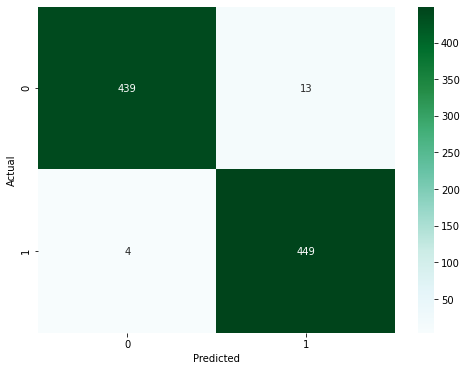


AUC Score: 0.9926742073492352


In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_classification_cleaned_toy_data_train.csv', 
                                                                   val_data_filename='emotion_classification_cleaned_toy_data_dev.csv', 
                                                                   batch_size=32)

MODEL_NAME = 'toy_dataset_uni_gru_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = False # changeable
RNN_TYPE = 'gru' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fpr1c, tpr1c, get_auc_value1c, thresholds1c = fit_model(model=model, 
                                                device=device,
                                                learning_rate=LEARNING_RATE,
                                                num_epochs=NUM_EPOCHS,
                                                root_path=SAVED_MODEL_PATH, 
                                                filepath=MODEL_NAME)

### CONFIGURATION 1d 
- Toy Dataset
- BiGRU

Size of TEXT vocabulary: 8448
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('depression', 1803), ('not', 693), ('just', 308), ('anxiety', 279), ('like', 239), ('good', 197), ('day', 195), ('love', 193), ('time', 177), ('know', 161)]
cuda
RNN(
  (embedding): Embedding(8448, 300, padding_idx=1)
  (rnn): GRU(300, 512, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 19,734,529 trainable parameters

Idx: 50, Train Loss: 0.2601
Idx: 100, Train Loss: 0.4179
Epoch 1: Train Loss: 0.46405 | Val. Loss: 0.08003 | Val. Acc: 0.98707 | Time Taken:  3.026s
Idx: 50, Train Loss: 0.2848
Idx: 100, Train Loss: 0.4342
Epoch 2: Train Loss: 0.39272 | Val. Loss: 0.07447 | Val. Acc: 0.98276 | Time Taken:  2.969s
Idx: 50, Train Loss: 0.3542
Idx: 100, Train Loss: 0.3776
Epoch 3: Train Loss

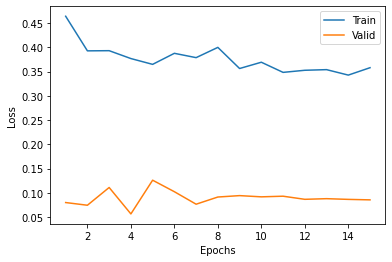

F1-Score and Confusion Matrix of the Validation Set

              precision    recall  f1-score   support

           0     0.9865    0.9712    0.9788       452
           1     0.9717    0.9868    0.9792       453

    accuracy                         0.9790       905
   macro avg     0.9791    0.9790    0.9790       905
weighted avg     0.9791    0.9790    0.9790       905





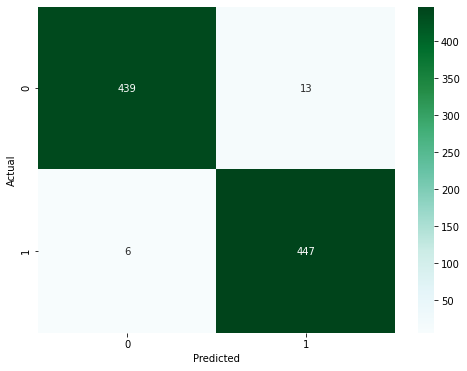


AUC Score: 0.9891578268768682


In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_classification_cleaned_toy_data_train.csv', 
                                                                   val_data_filename='emotion_classification_cleaned_toy_data_dev.csv', 
                                                                   batch_size=32)

MODEL_NAME = 'toy_dataset_bigru_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = True # changeable
RNN_TYPE = 'gru' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fpr1d, tpr1d, get_auc_value1d, thresholds1d = fit_model(model=model, 
                                                device=device,
                                                learning_rate=LEARNING_RATE,
                                                num_epochs=NUM_EPOCHS,
                                                root_path=SAVED_MODEL_PATH, 
                                                filepath=MODEL_NAME)

### CONFIGURATION 2a
- Short Text Twitter Dataset
- Uni-LSTM

Size of TEXT vocabulary: 3451
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('not', 345), ('just', 148), ('like', 110), ('day', 108), ('year', 103), ('feel', 102), ('life', 95), ('want', 85), ('today', 73), ('time', 72)]
cuda
RNN(
  (embedding): Embedding(3451, 300, padding_idx=1)
  (rnn): LSTM(300, 512, num_layers=4, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 9,531,429 trainable parameters

Epoch 1: Train Loss: 0.69115 | Val. Loss: 0.63757 | Val. Acc: 0.66558 | Time Taken:  0.607s
Epoch 2: Train Loss: 0.67668 | Val. Loss: 0.64571 | Val. Acc: 0.60633 | Time Taken:  0.534s
Validation Loss did not improve count: 1
Epoch 3: Train Loss: 0.65902 | Val. Loss: 0.62423 | Val. Acc: 0.71834 | Time Taken:  0.538s
Epoch 4: Train Loss: 0.61660 | Val. Loss: 0.58155 | Val. Acc: 0.67817 | Time Taken:  0.534

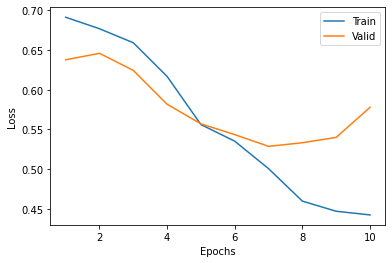

F1-Score and Confusion Matrix of the Validation Set

              precision    recall  f1-score   support

           0     0.6884    0.8204    0.7486       167
           1     0.7778    0.6287    0.6954       167

    accuracy                         0.7246       334
   macro avg     0.7331    0.7246    0.7220       334
weighted avg     0.7331    0.7246    0.7220       334





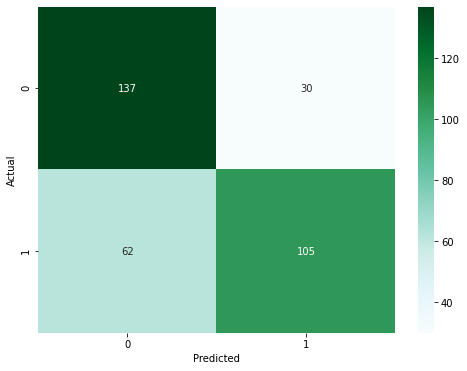


AUC Score: 0.8017497938255226


In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_classification_cleaned_short_text_train.csv', 
                                                                   val_data_filename='emotion_classification_cleaned_short_text_dev.csv', 
                                                                   batch_size=32)

MODEL_NAME = 'short_text_dataset_uni_lstm_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = False # changeable
RNN_TYPE = 'lstm' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fpr2a, tpr2a, get_auc_value2a, thresholds2a = fit_model(model=model, 
                                                device=device,
                                                learning_rate=LEARNING_RATE,
                                                num_epochs=NUM_EPOCHS,
                                                root_path=SAVED_MODEL_PATH, 
                                                filepath=MODEL_NAME)

### CONFIGURATION 2b
- Short Text Twitter Dataset
- BiLSTM

Size of TEXT vocabulary: 3451
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('not', 345), ('just', 148), ('like', 110), ('day', 108), ('year', 103), ('feel', 102), ('life', 95), ('want', 85), ('today', 73), ('time', 72)]
cuda
RNN(
  (embedding): Embedding(3451, 300, padding_idx=1)
  (rnn): LSTM(300, 512, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 23,793,701 trainable parameters

Epoch 1: Train Loss: 0.69745 | Val. Loss: 0.67867 | Val. Acc: 0.59700 | Time Taken:  1.268s
Epoch 2: Train Loss: 0.65719 | Val. Loss: 0.66010 | Val. Acc: 0.71023 | Time Taken:  1.198s
Epoch 3: Train Loss: 0.63866 | Val. Loss: 0.59807 | Val. Acc: 0.73174 | Time Taken:  1.197s
Epoch 4: Train Loss: 0.56877 | Val. Loss: 0.56888 | Val. Acc: 0.73255 | Time Taken:  1.197s
Epoch 5: Train Los

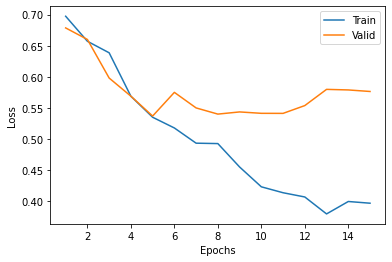

F1-Score and Confusion Matrix of the Validation Set

              precision    recall  f1-score   support

           0     0.7548    0.7006    0.7267       167
           1     0.7207    0.7725    0.7457       167

    accuracy                         0.7365       334
   macro avg     0.7378    0.7365    0.7362       334
weighted avg     0.7378    0.7365    0.7362       334





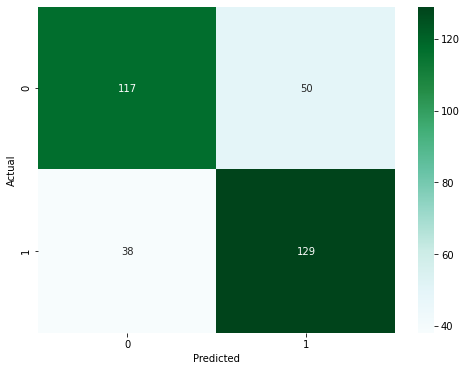


AUC Score: 0.8084908028254868


In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_classification_cleaned_short_text_train.csv', 
                                                                   val_data_filename='emotion_classification_cleaned_short_text_dev.csv', 
                                                                   batch_size=32)

MODEL_NAME = 'short_text_dataset_bilstm_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = True # changeable
RNN_TYPE = 'lstm' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fpr2b, tpr2b, get_auc_value2b, thresholds2b = fit_model(model=model, 
                                                device=device,
                                                learning_rate=LEARNING_RATE,
                                                num_epochs=NUM_EPOCHS,
                                                root_path=SAVED_MODEL_PATH, 
                                                filepath=MODEL_NAME)

### CONFIGURATION 2c
- Short Text Twitter Dataset
- Uni-GRU

Size of TEXT vocabulary: 3451
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('not', 345), ('just', 148), ('like', 110), ('day', 108), ('year', 103), ('feel', 102), ('life', 95), ('want', 85), ('today', 73), ('time', 72)]
cuda
RNN(
  (embedding): Embedding(3451, 300, padding_idx=1)
  (rnn): GRU(300, 512, num_layers=4, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 7,538,725 trainable parameters

Epoch 1: Train Loss: 0.69250 | Val. Loss: 0.62981 | Val. Acc: 0.66558 | Time Taken:  0.519s
Epoch 2: Train Loss: 0.64671 | Val. Loss: 0.64592 | Val. Acc: 0.68872 | Time Taken:  0.445s
Validation Loss did not improve count: 1
Epoch 3: Train Loss: 0.61934 | Val. Loss: 0.62378 | Val. Acc: 0.64529 | Time Taken:  0.443s
Epoch 4: Train Loss: 0.58328 | Val. Loss: 0.63054 | Val. Acc: 0.68385 | Time Taken:  0.447s

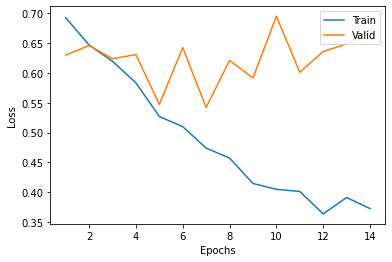

F1-Score and Confusion Matrix of the Validation Set

              precision    recall  f1-score   support

           0     0.7073    0.6946    0.7009       167
           1     0.7000    0.7126    0.7062       167

    accuracy                         0.7036       334
   macro avg     0.7037    0.7036    0.7036       334
weighted avg     0.7037    0.7036    0.7036       334





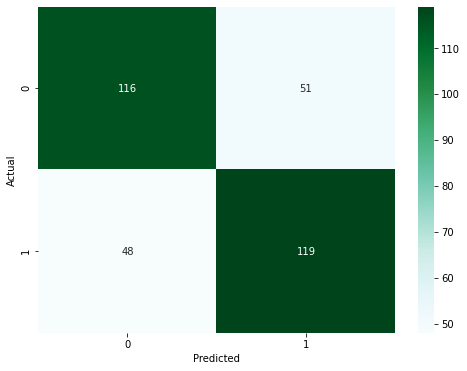


AUC Score: 0.7846104198788053


In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_classification_cleaned_short_text_train.csv', 
                                                                   val_data_filename='emotion_classification_cleaned_short_text_dev.csv', 
                                                                   batch_size=32)

MODEL_NAME = 'short_text_dataset_uni_gru_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = False # changeable
RNN_TYPE = 'gru' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fpr2c, tpr2c, get_auc_value2c, thresholds2c = fit_model(model=model, 
                                                device=device,
                                                learning_rate=LEARNING_RATE,
                                                num_epochs=NUM_EPOCHS,
                                                root_path=SAVED_MODEL_PATH, 
                                                filepath=MODEL_NAME)

### CONFIGURATION 2d
- Short Text Twitter Dataset
- BiGRU

Size of TEXT vocabulary: 3451
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('not', 345), ('just', 148), ('like', 110), ('day', 108), ('year', 103), ('feel', 102), ('life', 95), ('want', 85), ('today', 73), ('time', 72)]
cuda
RNN(
  (embedding): Embedding(3451, 300, padding_idx=1)
  (rnn): GRU(300, 512, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 18,235,429 trainable parameters

Epoch 1: Train Loss: 0.66908 | Val. Loss: 0.60890 | Val. Acc: 0.71388 | Time Taken:  1.062s
Epoch 2: Train Loss: 0.64188 | Val. Loss: 0.65409 | Val. Acc: 0.59416 | Time Taken:  0.975s
Validation Loss did not improve count: 1
Epoch 3: Train Loss: 0.62208 | Val. Loss: 0.60243 | Val. Acc: 0.68425 | Time Taken:  0.977s
Epoch 4: Train Loss: 0.56586 | Val. Loss: 0.52639 | Val. Acc: 0.72321 

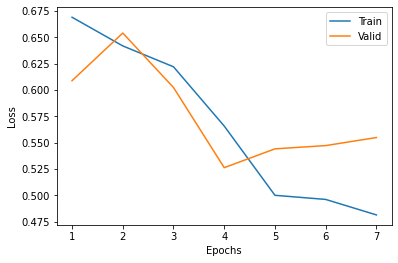

F1-Score and Confusion Matrix of the Validation Set

              precision    recall  f1-score   support

           0     0.6949    0.7365    0.7151       167
           1     0.7197    0.6766    0.6975       167

    accuracy                         0.7066       334
   macro avg     0.7073    0.7066    0.7063       334
weighted avg     0.7073    0.7066    0.7063       334





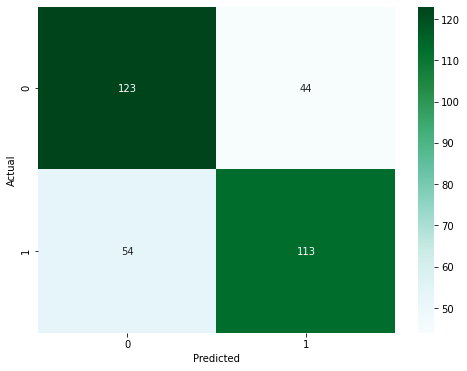


AUC Score: 0.7950804976872601


In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_classification_cleaned_short_text_train.csv', 
                                                                   val_data_filename='emotion_classification_cleaned_short_text_dev.csv', 
                                                                   batch_size=32)

MODEL_NAME = 'short_text_dataset_bigru_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = True # changeable
RNN_TYPE = 'gru' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fpr2d, tpr2d, get_auc_value2d, thresholds2d = fit_model(model=model, 
                                                device=device,
                                                learning_rate=LEARNING_RATE,
                                                num_epochs=NUM_EPOCHS,
                                                root_path=SAVED_MODEL_PATH, 
                                                filepath=MODEL_NAME)

### CONFIGURATION 3a
- Long Text Reddit Dataset
- Uni-LSTM

Size of TEXT vocabulary: 16874
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('not', 8197), ('just', 3308), ('like', 2965), ('feel', 2168), ('friend', 2145), ('know', 2132), ('time', 2107), ('want', 1811), ('me', 1746), ('really', 1720)]
cuda
RNN(
  (embedding): Embedding(16874, 300, padding_idx=1)
  (rnn): LSTM(300, 512, num_layers=4, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 13,558,329 trainable parameters

Idx: 50, Train Loss: 0.6484
Epoch 1: Train Loss: 0.66599 | Val. Loss: 0.60849 | Val. Acc: 0.67034 | Time Taken:  6.550s
Idx: 50, Train Loss: 0.4946
Epoch 2: Train Loss: 0.59376 | Val. Loss: 0.56173 | Val. Acc: 0.77451 | Time Taken:  6.533s
Idx: 50, Train Loss: 0.7978
Epoch 3: Train Loss: 0.66128 | Val. Loss: 0.58030 | Val. Acc: 0.72365 | Time Taken:  6.510s
Validation Loss did not impr

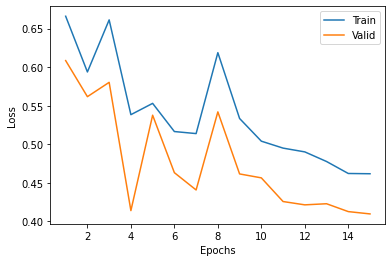

F1-Score and Confusion Matrix of the Validation Set

              precision    recall  f1-score   support

           0     0.8281    0.8249    0.8265       257
           1     0.8263    0.8295    0.8279       258

    accuracy                         0.8272       515
   macro avg     0.8272    0.8272    0.8272       515
weighted avg     0.8272    0.8272    0.8272       515





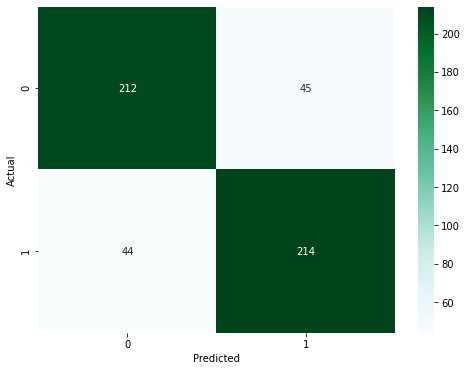


AUC Score: 0.8971435465870359


In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_classification_cleaned_long_text_train.csv', 
                                                                   val_data_filename='emotion_classification_cleaned_long_text_dev.csv', 
                                                                   batch_size=32)

MODEL_NAME = 'long_text_dataset_uni_lstm_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = False # changeable
RNN_TYPE = 'lstm' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fpr3a, tpr3a, get_auc_value3a, thresholds3a = fit_model(model=model, 
                                                device=device,
                                                learning_rate=LEARNING_RATE,
                                                num_epochs=NUM_EPOCHS,
                                                root_path=SAVED_MODEL_PATH, 
                                                filepath=MODEL_NAME)

### CONFIGURATION 3b
- Long Text Reddit Dataset
- Bi-LSTM

Size of TEXT vocabulary: 16874
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('not', 8197), ('just', 3308), ('like', 2965), ('feel', 2168), ('friend', 2145), ('know', 2132), ('time', 2107), ('want', 1811), ('me', 1746), ('really', 1720)]
cuda
RNN(
  (embedding): Embedding(16874, 300, padding_idx=1)
  (rnn): LSTM(300, 512, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 27,820,601 trainable parameters

Idx: 50, Train Loss: 0.4906
Epoch 1: Train Loss: 0.64771 | Val. Loss: 0.59259 | Val. Acc: 0.81495 | Time Taken:  14.954s
Idx: 50, Train Loss: 0.5387
Epoch 2: Train Loss: 0.55806 | Val. Loss: 0.45605 | Val. Acc: 0.81373 | Time Taken:  14.972s
Idx: 50, Train Loss: 0.5264
Epoch 3: Train Loss: 0.50404 | Val. Loss: 0.42271 | Val. Acc: 0.82475 | Time Taken:  15.012s
Idx: 

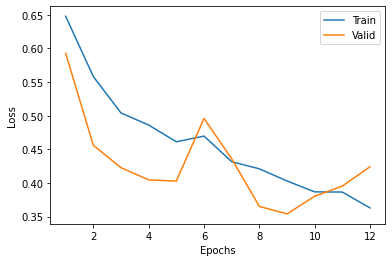

F1-Score and Confusion Matrix of the Validation Set

              precision    recall  f1-score   support

           0     0.8943    0.8560    0.8748       257
           1     0.8625    0.8992    0.8805       258

    accuracy                         0.8777       515
   macro avg     0.8784    0.8776    0.8776       515
weighted avg     0.8784    0.8777    0.8776       515





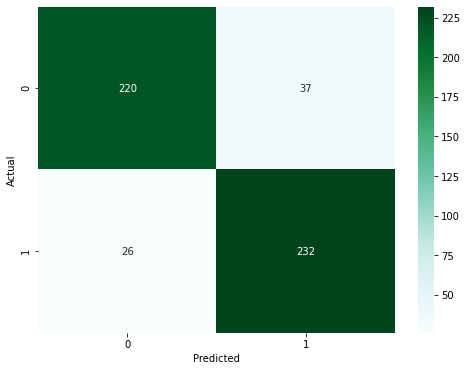


AUC Score: 0.9408047537176123


In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_classification_cleaned_long_text_train.csv', 
                                                                   val_data_filename='emotion_classification_cleaned_long_text_dev.csv', 
                                                                   batch_size=32)

MODEL_NAME = 'long_text_dataset_bilstm_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = True # changeable
RNN_TYPE = 'lstm' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fpr3b, tpr3b, get_auc_value3b, thresholds3b = fit_model(model=model, 
                                                device=device,
                                                learning_rate=LEARNING_RATE,
                                                num_epochs=NUM_EPOCHS,
                                                root_path=SAVED_MODEL_PATH, 
                                                filepath=MODEL_NAME)

### CONFIGURATION 3c
- Long Text Reddit Dataset
- Uni-GRU

Size of TEXT vocabulary: 16874
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('not', 8197), ('just', 3308), ('like', 2965), ('feel', 2168), ('friend', 2145), ('know', 2132), ('time', 2107), ('want', 1811), ('me', 1746), ('really', 1720)]
cuda
RNN(
  (embedding): Embedding(16874, 300, padding_idx=1)
  (rnn): GRU(300, 512, num_layers=4, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 11,565,625 trainable parameters

Idx: 50, Train Loss: 0.6490
Epoch 1: Train Loss: 0.67142 | Val. Loss: 0.66854 | Val. Acc: 0.54044 | Time Taken:  5.729s
Idx: 50, Train Loss: 0.5405
Epoch 2: Train Loss: 0.60714 | Val. Loss: 0.65362 | Val. Acc: 0.56801 | Time Taken:  5.654s
Idx: 50, Train Loss: 0.5421
Epoch 3: Train Loss: 0.57420 | Val. Loss: 0.42474 | Val. Acc: 0.84007 | Time Taken:  5.647s
Idx: 50, Train Loss: 0.5165
E

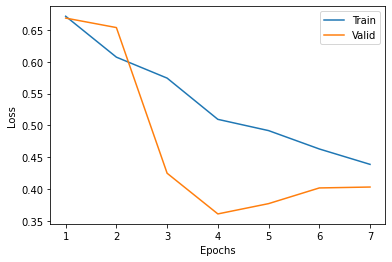

F1-Score and Confusion Matrix of the Validation Set

              precision    recall  f1-score   support

           0     0.7508    0.9261    0.8293       257
           1     0.9040    0.6938    0.7851       258

    accuracy                         0.8097       515
   macro avg     0.8274    0.8099    0.8072       515
weighted avg     0.8276    0.8097    0.8071       515





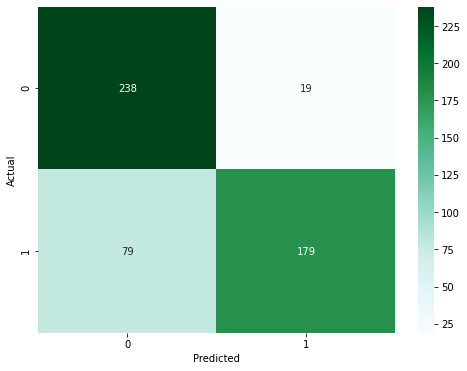


AUC Score: 0.9090730853919706


In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_classification_cleaned_long_text_train.csv', 
                                                                   val_data_filename='emotion_classification_cleaned_long_text_dev.csv', 
                                                                   batch_size=32)

MODEL_NAME = 'long_text_dataset_uni_gru_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = False # changeable
RNN_TYPE = 'gru' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fpr3c, tpr3c, get_auc_value3c, thresholds3c = fit_model(model=model, 
                                                device=device,
                                                learning_rate=LEARNING_RATE,
                                                num_epochs=NUM_EPOCHS,
                                                root_path=SAVED_MODEL_PATH, 
                                                filepath=MODEL_NAME)

### CONFIGURATION 3d
- Long Text Reddit Dataset
- BiGRU

Size of TEXT vocabulary: 16874
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('not', 8197), ('just', 3308), ('like', 2965), ('feel', 2168), ('friend', 2145), ('know', 2132), ('time', 2107), ('want', 1811), ('me', 1746), ('really', 1720)]
cuda
RNN(
  (embedding): Embedding(16874, 300, padding_idx=1)
  (rnn): GRU(300, 512, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 22,262,329 trainable parameters

Idx: 50, Train Loss: 0.5216
Epoch 1: Train Loss: 0.62715 | Val. Loss: 0.53089 | Val. Acc: 0.75368 | Time Taken:  12.532s
Idx: 50, Train Loss: 0.5817
Epoch 2: Train Loss: 0.53893 | Val. Loss: 0.45413 | Val. Acc: 0.81495 | Time Taken:  12.506s
Idx: 50, Train Loss: 0.6791
Epoch 3: Train Loss: 0.53631 | Val. Loss: 0.43028 | Val. Acc: 0.80208 | Time Taken:  12.546s
Idx: 5

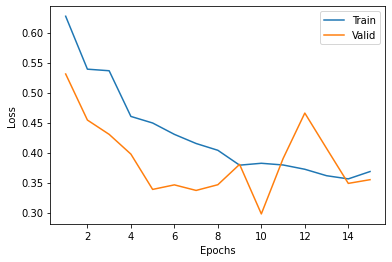

F1-Score and Confusion Matrix of the Validation Set

              precision    recall  f1-score   support

           0     0.8826    0.8482    0.8651       257
           1     0.8545    0.8876    0.8707       258

    accuracy                         0.8680       515
   macro avg     0.8685    0.8679    0.8679       515
weighted avg     0.8685    0.8680    0.8679       515





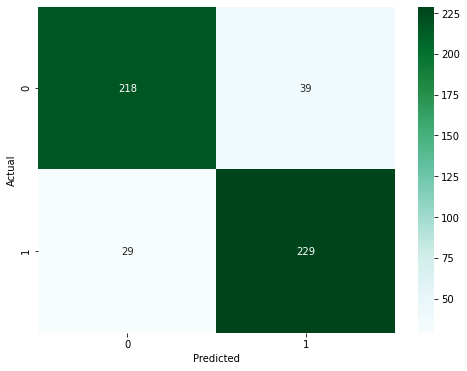


AUC Score: 0.9393870841251168


In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_classification_cleaned_long_text_train.csv', 
                                                                   val_data_filename='emotion_classification_cleaned_long_text_dev.csv', 
                                                                   batch_size=32)

MODEL_NAME = 'long_text_dataset_bigru_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = True # changeable
RNN_TYPE = 'gru' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fpr3d, tpr3d, get_auc_value3d, thresholds3d = fit_model(model=model, 
                                                device=device,
                                                learning_rate=LEARNING_RATE,
                                                num_epochs=NUM_EPOCHS,
                                                root_path=SAVED_MODEL_PATH, 
                                                filepath=MODEL_NAME)

### CONFIGURATION 4a
- Mixed of Short + Long Text Dataset
- Uni-LSTM

Size of TEXT vocabulary: 17720
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('not', 8542), ('just', 3456), ('like', 3075), ('feel', 2270), ('know', 2203), ('time', 2179), ('friend', 2172), ('want', 1896), ('me', 1797), ('really', 1767)]
cuda
RNN(
  (embedding): Embedding(17720, 300, padding_idx=1)
  (rnn): LSTM(300, 512, num_layers=4, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 13,812,129 trainable parameters

Idx: 50, Train Loss: 0.6825
Idx: 100, Train Loss: 0.6383
Epoch 1: Train Loss: 0.67221 | Val. Loss: 0.60191 | Val. Acc: 0.67341 | Time Taken:  7.211s
Idx: 50, Train Loss: 0.6048
Idx: 100, Train Loss: 0.7387
Epoch 2: Train Loss: 0.69008 | Val. Loss: 0.65383 | Val. Acc: 0.58109 | Time Taken:  7.230s
Validation Loss did not improve count: 1
Idx: 50, Train Loss: 0.6548
Idx: 100, Train Loss:

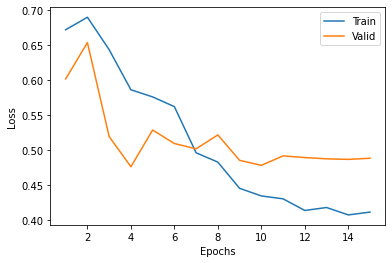

F1-Score and Confusion Matrix of the Validation Set

              precision    recall  f1-score   support

           0     0.7713    0.7476    0.7593       424
           1     0.7557    0.7788    0.7671       425

    accuracy                         0.7633       849
   macro avg     0.7635    0.7632    0.7632       849
weighted avg     0.7635    0.7633    0.7632       849





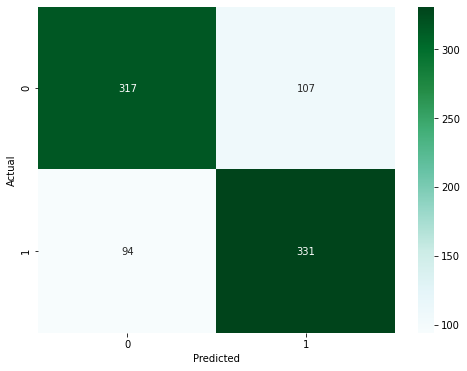


AUC Score: 0.8545893451720311


In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_classification_cleaned_combined_text_train.csv', 
                                                                   val_data_filename='emotion_classification_cleaned_combined_text_dev.csv', 
                                                                   batch_size=32)

MODEL_NAME = 'combined_text_dataset_uni_lstm_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = False # changeable
RNN_TYPE = 'lstm' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fpr4a, tpr4a, get_auc_value4a, thresholds4a = fit_model(model=model, 
                                                device=device,
                                                learning_rate=LEARNING_RATE,
                                                num_epochs=NUM_EPOCHS,
                                                root_path=SAVED_MODEL_PATH, 
                                                filepath=MODEL_NAME)

### CONFIGURATION 4b
- Mixed of Short + Long Text Dataset
- BiLSTM

Size of TEXT vocabulary: 17720
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('not', 8542), ('just', 3456), ('like', 3075), ('feel', 2270), ('know', 2203), ('time', 2179), ('friend', 2172), ('want', 1896), ('me', 1797), ('really', 1767)]
cuda
RNN(
  (embedding): Embedding(17720, 300, padding_idx=1)
  (rnn): LSTM(300, 512, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 28,074,401 trainable parameters

Idx: 50, Train Loss: 0.6855
Idx: 100, Train Loss: 0.7144
Epoch 1: Train Loss: 0.66492 | Val. Loss: 0.60108 | Val. Acc: 0.76416 | Time Taken:  16.270s
Idx: 50, Train Loss: 0.5772
Idx: 100, Train Loss: 0.5457
Epoch 2: Train Loss: 0.58760 | Val. Loss: 0.50740 | Val. Acc: 0.79296 | Time Taken:  16.420s
Idx: 50, Train Loss: 0.5201
Idx: 100, Train Loss: 0.4706
Epoch 3: Tr

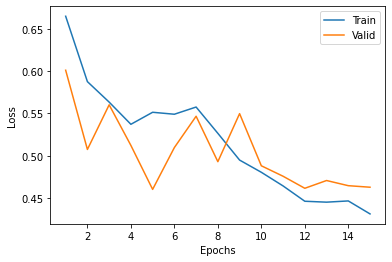

F1-Score and Confusion Matrix of the Validation Set

              precision    recall  f1-score   support

           0     0.7941    0.8184    0.8060       424
           1     0.8131    0.7882    0.8005       425

    accuracy                         0.8033       849
   macro avg     0.8036    0.8033    0.8033       849
weighted avg     0.8036    0.8033    0.8033       849





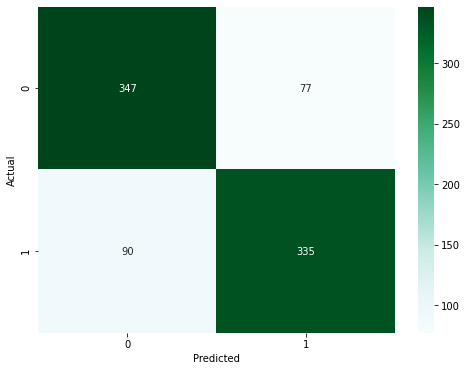


AUC Score: 0.866320754716981


In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_classification_cleaned_combined_text_train.csv', 
                                                                   val_data_filename='emotion_classification_cleaned_combined_text_dev.csv', 
                                                                   batch_size=32)

MODEL_NAME = 'combined_text_dataset_bilstm_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = True # changeable
RNN_TYPE = 'lstm' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fpr4b, tpr4b, get_auc_value4b, thresholds4b = fit_model(model=model, 
                                                device=device,
                                                learning_rate=LEARNING_RATE,
                                                num_epochs=NUM_EPOCHS,
                                                root_path=SAVED_MODEL_PATH, 
                                                filepath=MODEL_NAME)

### CONFIGURATION 4c
- Mixed of Short + Long Text Dataset
- Uni-GRU

Size of TEXT vocabulary: 17720
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('not', 8542), ('just', 3456), ('like', 3075), ('feel', 2270), ('know', 2203), ('time', 2179), ('friend', 2172), ('want', 1896), ('me', 1797), ('really', 1767)]
cuda
RNN(
  (embedding): Embedding(17720, 300, padding_idx=1)
  (rnn): GRU(300, 512, num_layers=4, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 11,819,425 trainable parameters

Idx: 50, Train Loss: 0.6818
Idx: 100, Train Loss: 0.7495
Epoch 1: Train Loss: 0.67815 | Val. Loss: 0.61408 | Val. Acc: 0.70711 | Time Taken:  6.178s
Idx: 50, Train Loss: 0.6688
Idx: 100, Train Loss: 0.6361
Epoch 2: Train Loss: 0.63399 | Val. Loss: 0.56773 | Val. Acc: 0.72985 | Time Taken:  6.181s
Idx: 50, Train Loss: 0.3565
Idx: 100, Train Loss: 0.6389
Epoch 3: Train Loss: 0.60493 | Val

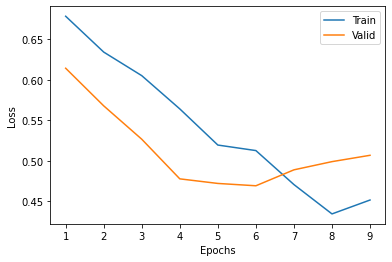

F1-Score and Confusion Matrix of the Validation Set

              precision    recall  f1-score   support

           0     0.7471    0.7594    0.7532       424
           1     0.7560    0.7435    0.7497       425

    accuracy                         0.7515       849
   macro avg     0.7515    0.7515    0.7515       849
weighted avg     0.7515    0.7515    0.7515       849





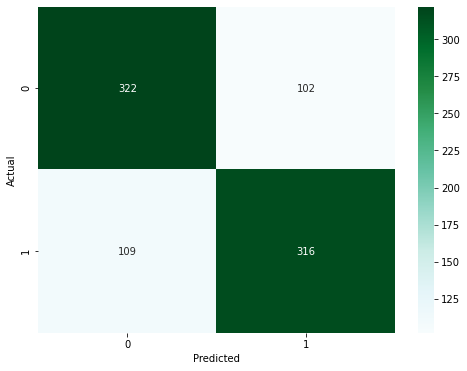


AUC Score: 0.8311653718091011


In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_classification_cleaned_combined_text_train.csv', 
                                                                   val_data_filename='emotion_classification_cleaned_combined_text_dev.csv', 
                                                                   batch_size=32)

MODEL_NAME = 'combined_text_dataset_uni_gru_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = False # changeable
RNN_TYPE = 'gru' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fpr4c, tpr4c, get_auc_value4c, thresholds4c = fit_model(model=model, 
                                                device=device,
                                                learning_rate=LEARNING_RATE,
                                                num_epochs=NUM_EPOCHS,
                                                root_path=SAVED_MODEL_PATH, 
                                                filepath=MODEL_NAME)

### CONFIGURATION 4d
- Mixed of Short + Long Text Dataset
- BiGRU

Size of TEXT vocabulary: 17720
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('not', 8542), ('just', 3456), ('like', 3075), ('feel', 2270), ('know', 2203), ('time', 2179), ('friend', 2172), ('want', 1896), ('me', 1797), ('really', 1767)]
cuda
RNN(
  (embedding): Embedding(17720, 300, padding_idx=1)
  (rnn): GRU(300, 512, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 22,516,129 trainable parameters

Idx: 50, Train Loss: 0.7101
Idx: 100, Train Loss: 0.6158
Epoch 1: Train Loss: 0.64711 | Val. Loss: 0.61188 | Val. Acc: 0.61424 | Time Taken:  14.068s
Idx: 50, Train Loss: 0.7038
Idx: 100, Train Loss: 0.5372
Epoch 2: Train Loss: 0.61070 | Val. Loss: 0.50253 | Val. Acc: 0.78499 | Time Taken:  14.282s
Idx: 50, Train Loss: 0.3933
Idx: 100, Train Loss: 0.4334
Epoch 3: Tra

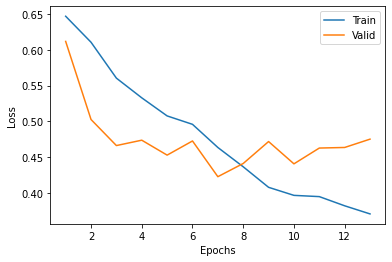

F1-Score and Confusion Matrix of the Validation Set

              precision    recall  f1-score   support

           0     0.7913    0.7689    0.7799       424
           1     0.7757    0.7976    0.7865       425

    accuracy                         0.7833       849
   macro avg     0.7835    0.7833    0.7832       849
weighted avg     0.7835    0.7833    0.7832       849





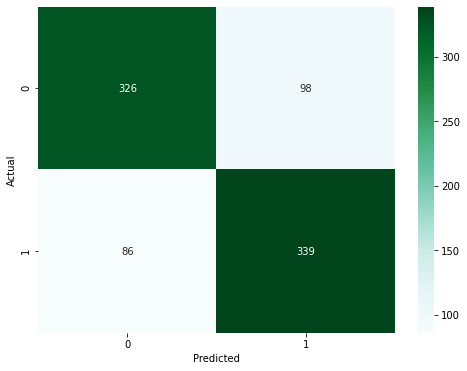


AUC Score: 0.8769977802441732


In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_classification_cleaned_combined_text_train.csv', 
                                                                   val_data_filename='emotion_classification_cleaned_combined_text_dev.csv', 
                                                                   batch_size=32)

MODEL_NAME = 'combined_text_dataset_bigru_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = True # changeable
RNN_TYPE = 'gru' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fpr4d, tpr4d, get_auc_value4d, thresholds4d = fit_model(model=model, 
                                                device=device,
                                                learning_rate=LEARNING_RATE,
                                                num_epochs=NUM_EPOCHS,
                                                root_path=SAVED_MODEL_PATH, 
                                                filepath=MODEL_NAME)

## Fill up the dataframe of saved values for ROC curve


In [ ]:
# helper function to to plot the ROC curve
def plot_roc(fpr, tpr, auc_value): # pass in a subset of the list
    """
    - Print AUC
    - Plot ROC
    """
    color_set = ['b','g','r','k']
    label_name = ['UniLSTM', 'BiLSTM', 'UniGRU', 'BiGRU']
    # Plot ROC AUC
    print('ROC Curve')
    plt.rcParams["figure.figsize"] = [12,8]
    plt.title('Receiver Operating Characteristic')
    for i in range(len(auc_value)):
        plt.plot(fpr[i], tpr[i], color_set[i], label = f'{label_name[i]} AUC = {auc_value[i]:.4f}')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
# collate the values in a list for backup
fpr_list = [fpr1a,fpr1b,fpr1c,fpr1d,
            fpr2a,fpr2b,fpr2c,fpr2d,
            fpr3a,fpr3b,fpr3c,fpr3d,
            fpr4a,fpr4b,fpr4c,fpr4d]

tpr_list = [tpr1a,tpr1b,tpr1c,tpr1d,
            tpr2a,tpr2b,tpr2c,tpr2d,
            tpr3a,tpr3b,tpr3c,tpr3d,
            tpr4a,tpr4b,tpr4c,tpr4d]

get_auc_value_list = [get_auc_value1a,get_auc_value1b,get_auc_value1c,get_auc_value1d,
                      get_auc_value2a,get_auc_value2b,get_auc_value2c,get_auc_value2d,
                      get_auc_value3a,get_auc_value3b,get_auc_value3c,get_auc_value3d,
                      get_auc_value4a,get_auc_value4b,get_auc_value4c,get_auc_value4d]

thresholds_list = [thresholds1a,thresholds1b,thresholds1c,thresholds1d,
                   thresholds2a,thresholds2b,thresholds2c,thresholds2d,
                   thresholds3a,thresholds3b,thresholds3c,thresholds3d,
                   thresholds4a,thresholds4b,thresholds4c,thresholds4d]

# create a dataframe to store all the values
roc_auc_df = pd.DataFrame()
roc_auc_df['fpr'] = fpr_list
roc_auc_df['tpr'] = tpr_list
roc_auc_df['get_auc_value'] = get_auc_value_list
roc_auc_df['thresholds'] = thresholds_list

# export dataframe as backup
roc_auc_df.to_csv(SAVED_MODEL_PATH+'roc_auc.csv', index=False)

## Get the 4 sets of ROC Curve for different dataset

ROC Curve


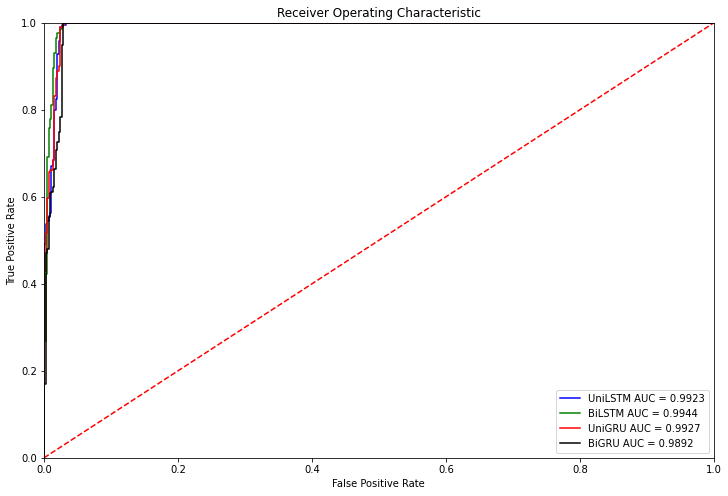

In [ ]:
# toy dataset
plot_roc(fpr_list[:4], tpr_list[:4], get_auc_value_list[:4])

ROC Curve


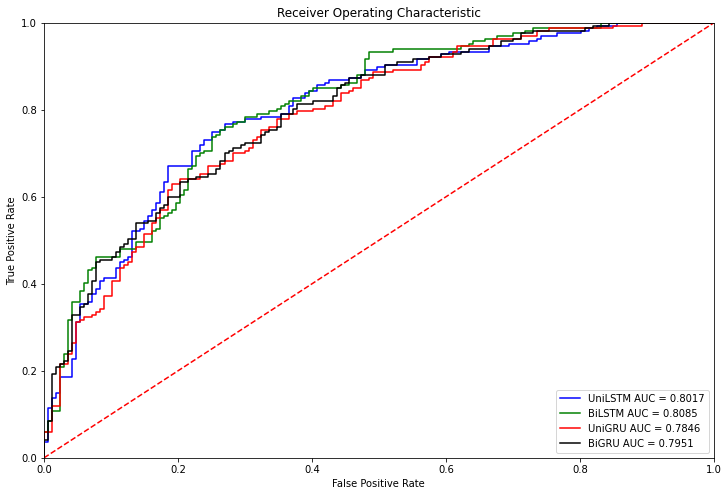

In [ ]:
# short text twitter
plot_roc(fpr_list[4:8], tpr_list[4:8], get_auc_value_list[4:8])

ROC Curve


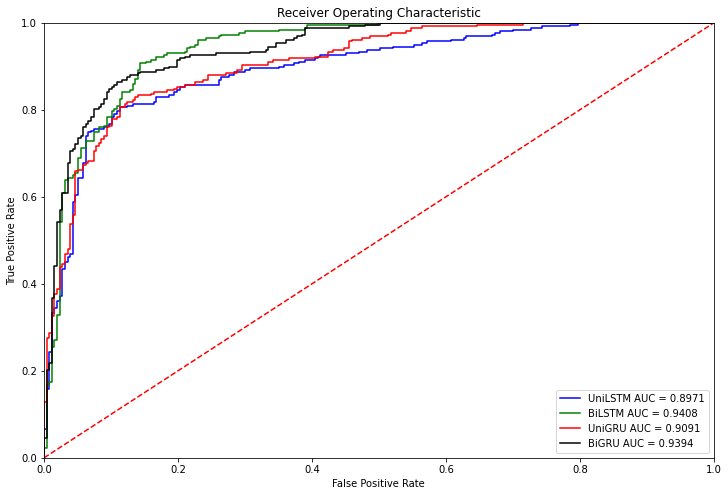

In [ ]:
# long text reddit
plot_roc(fpr_list[8:12], tpr_list[8:12], get_auc_value_list[8:12])

ROC Curve


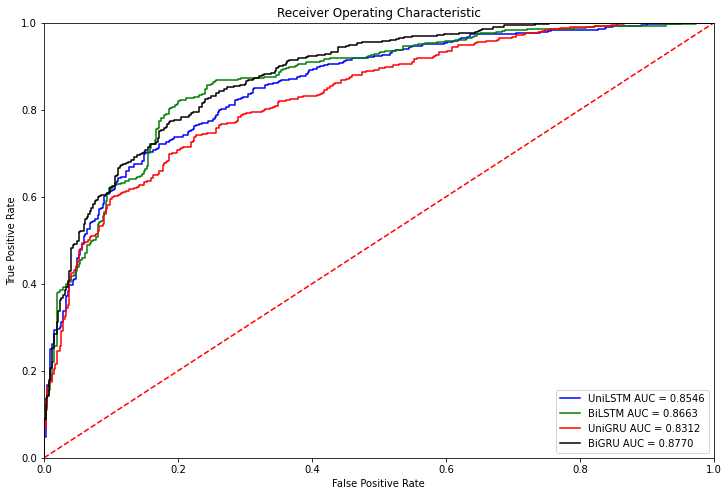

In [ ]:
# mixed text twitter and reddit
plot_roc(fpr_list[12:], tpr_list[12:], get_auc_value_list[12:])

## Predict with your own sentences

In [ ]:
PATH = SAVED_MODEL_PATH+'combined_text_dataset_bigru_model.pt'
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_classification_cleaned_combined_text_train.csv', 
                                                                   val_data_filename='emotion_classification_cleaned_combined_text_dev.csv', 
                                                                   batch_size=32)

MODEL_NAME = 'combined_text_dataset_bigru_model.pt'

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 5e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
N_LAYERS = 4 
BIDIRECTIONAL = True # changeable
RNN_TYPE = 'gru' # changeable
DROPOUT = 0.5
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)

model.load_state_dict(torch.load(PATH))

.vector_cache/wiki.simple.vec: 293MB [00:27, 10.7MB/s]                           
100%|██████████| 111051/111051 [00:13<00:00, 7980.57it/s]


Size of TEXT vocabulary: 17720
Size of LABEL vocabulary: 2
Top 10 most frequent word in the vocabulary: [('not', 8542), ('just', 3456), ('like', 3075), ('feel', 2270), ('know', 2203), ('time', 2179), ('friend', 2172), ('want', 1896), ('me', 1797), ('really', 1767)]
cuda


<All keys matched successfully>

In [ ]:
def predict(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]  #tokenize the sentence 
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]          #convert to integer sequence
    length = [len(indexed)]                                    #compute no. of words
    tensor = torch.LongTensor(indexed).to('cpu')              #convert to tensor
    tensor = tensor.unsqueeze(1).T                             #reshape in form of batch,no. of words
    
    length_tensor = torch.LongTensor(length)                   #convert to tensor
    
    prediction = model(tensor, length_tensor).squeeze(1)       #prediction 

    rounded_preds = 1-torch.sigmoid(prediction) #torch.round(torch.sigmoid(prediction))
    predict_class = rounded_preds.tolist()[0]
    return predict_class   

In [ ]:
# test sentences
test_sen1 = "Hi hello depression and anxiety are the worst"
test_sen2 = "happy"

predict_class_1 = predict(model, test_sen1) 
print(predict_class_1)

predict_class_2 = predict(model, test_sen2) 
print(predict_class_2)

0.9155312776565552
0.416329562664032


In [ ]:
predict(model, "i want to die, depression")

0.8597148656845093

In [ ]:
predict(model, "hate hiding life real body know wish did ask talk say want say stop saying jst want hear mabye say want hear mabye happy self wish not want ssoo anoying trying act like just happy corse kinda body want try ft hid real agaonst parent wanted hate thing hold dear like stupid basseball ur camping fishing say pinko liberal idea evr mean thnk havve say right think try save whale instead helping themon thier way extinction say merely nature isnt killing god graciously given putting ite death isnt just way thatwe differnt")

0.18587476015090942

In [ ]:
predict(model, "condition diagnosed anxiety depression not let define me negative energy feel paper art therapy not depression emoji heavy red heartemoji glowing star fuckdepression changedirection linkinpark")

0.6923927068710327

In [ ]:
predict(model, "exercising regularly cut risk depression study suggests")

0.8756897449493408

In [ ]:
predict(model, "depression depression depression")

0.774844765663147

In [ ]:
predict(model, "i am very nice")

0.721502423286438

In [ ]:
predict(model,"snuggle poor baby got bit something stay bed snuggle wanimals")

0.850324273109436

In [ ]:
predict(model, "suck it up, you cause depression")

0.8754550218582153

In [ ]:
predict(model, "life bullshit think family care help you lie parent said went deep anger bad worse age care helping me sore throat oh jesus walkin clinic immediately say extremely sad feel happiness anymore oh yeah totally fix having talk month mental breakdown feel like want die not flying fuck mental state talk just say shit like positive started working week not year injured feel it used love working feel like betrayed me gonna doomed skinny depressed appetite eat enough sake hate life slowly wasted everyday dreamt famous celebrity ")

0.8855053782463074

In [ ]:
predict(model, "pissed wife mother law new parent month old baby wife day look like care baby clean dish laundry cook dinner timesweek day look like help taking care baby hoursday wife rest time work hoursday business run clean mess wife make house make breakfast lunch all just family gathering mother law said relative loud not contribute helping wife literally depressed lost it talked way defend myself pissed just want monster law pile shit lazy daughter actually know half story fing business talking dirt back")

0.05129319429397583

In [ ]:
predict(model, "goodbye world")

0.6544991731643677

In [ ]:
predict(model, 'most depressing meal i ever had')

0.8654383420944214

In [ ]:
predict(model,'i feel so sad and angry at the same time, depressed')

0.8934894800186157